Step 1: Importing Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

c:\Users\Maharrani Raisha\anaconda3\envs\dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('Resources/walmart-sales-dataset-of-45stores.csv')

Step 2: Basic Data Inspection

In [3]:
# Shape of the data
print(df.shape)

(6435, 8)


In [4]:
# First and last few rows
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
df.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667
6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667


In [6]:
# Data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

In [8]:
print(df.dtypes)

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object


In [9]:
# Missing values
print(df.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [10]:
# Identify duplicates
duplicates = df.duplicated()
print(duplicates.sum())


0


In [11]:
# summary statistics for numerical columns
df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


In [12]:
#Coorelation between weekly sales and temperature 
correlation = df[["Weekly_Sales", "Temperature"]].corr()
correlation

,Weekly_Sales,Temperature
Weekly_Sales,1.00000,-0.06381
Temperature,-0.06381,1.00000


The correlation between Weekly_Sales and Temperature is -0.06381, which is a very weak negative correlation. This means that as the temperature increases, the weekly sales tend to decrease, but the relationship is not strong.

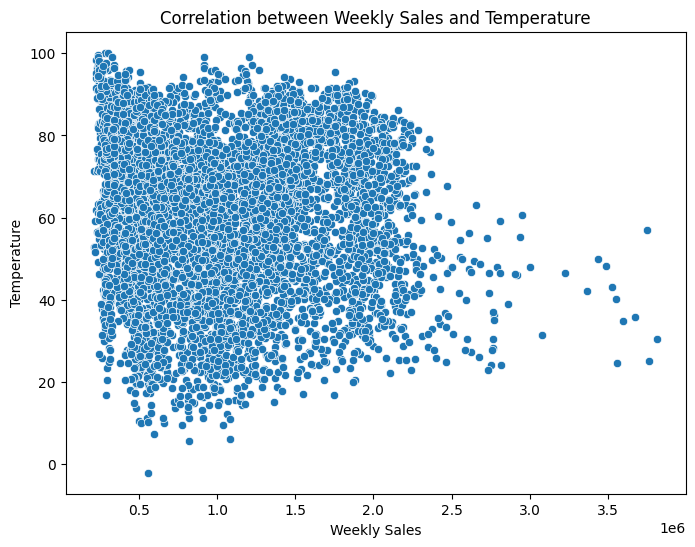

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Weekly_Sales", y="Temperature", data=df)
plt.title("Correlation between Weekly Sales and Temperature")
plt.xlabel("Weekly Sales")
plt.ylabel("Temperature")
plt.show()

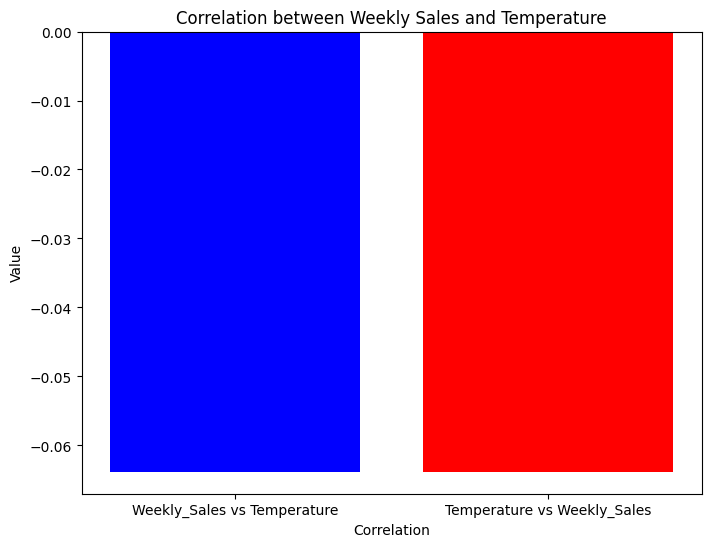

In [14]:
plt.figure(figsize=(8, 6))
plt.bar(range(2), [correlation.iloc[0, 1], correlation.iloc[1, 0]], color=['b', 'r'])
plt.xticks(range(2), ['Weekly_Sales vs Temperature', 'Temperature vs Weekly_Sales'])
plt.xlabel('Correlation')
plt.ylabel('Value')
plt.title('Correlation between Weekly Sales and Temperature')
plt.show()

Linear Regression Model

Coefficient: [-1804.5606034]
Intercept: 1155274.3911792273


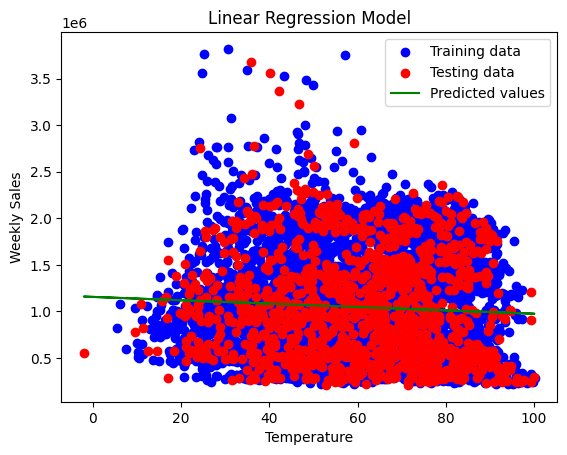

In [15]:

X = df[['Temperature']]  # independent variable
y = df['Weekly_Sales']  # dependent variable

# Training  and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Linear regression model
regressor = LinearRegression()

# model Training
regressor.fit(X_train, y_train)

# testing data predictions
y_pred_test = regressor.predict(X_test)

print(f'Coefficient: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')

# Train and Test data plot
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='red', label='Testing data')
plt.plot(X_test, y_pred_test, color='green', label='Predicted values')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.title('Linear Regression Model')
plt.legend()
plt.show()

In [16]:
temperature = 64.88
weekly_sales_prediction = regressor.predict([[temperature]])
print(f'Predicted weekly sales for temperature {temperature}: {weekly_sales_prediction[0]}')

Predicted weekly sales for temperature 64.88: 1038194.4992309465


c:\Users\Maharrani Raisha\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
